# graph_05_06_02_w

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/measurements/noise_model_zne/master_thesis_qaoa'))

In [2]:
import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

from helpers import *
from shared.QiskitMaxcut import *
from shared.graph_helper import *

In [3]:
%load_ext autoreload
%autoreload 2

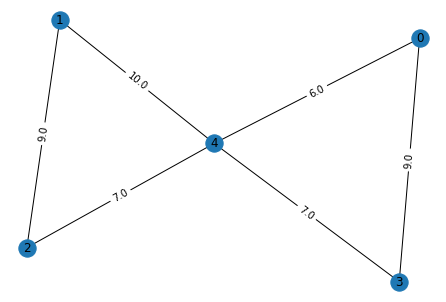

In [4]:
# ---- Define graph and MaxCut ----
filename = "graph_05_06_02_w.txt"
graph = load_nx_graph_from(f"../data/{filename}")
opt_max_cut = -get_max_cut(graph.name)
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

### Goemans Williamson Solution

In [47]:
%matplotlib inline

In [52]:
optimizer = GoemansWilliamsonOptimizer(2)
result = optimizer.solve(max_cut_qubo)
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

optimal function value: 35.0
optimal value: [0 1 0 1 0]
status: SUCCESS
00011: value: -32.000, probability: 50.0%
01010: value: -35.000, probability: 50.0%
Expectation Value: -33.5
Highest Exp.Value: -32 with 50.0 %
Lowest Exp.Value: -35 with 50.0 %
Highest Probability: -35 with 50.0 %
Ratio r: 0.5
Approiximation ratio: 0.9571428571428572
MSE: 2.25
RMSE: 1.5


## Parameters

In [6]:
BACKEND, EVAL_NUM, MAX_ITER, MAX_P, SHOTS, init_points = load_configs(graph.name)
display_configs()
all_results = {}

Backend = Simulator_Noise_Model
EVAL_NUM = 50
MAX_ITER = 0
MAX_P = 4
SHOTS = 1024
Initial_Points = [array([-3.33412359,  5.45892711]), array([ 0.47267939,  3.07283929, -3.80560601,  3.86218767]), array([-6.74717392, -0.9163878 , -4.77892508,  1.93667299, -3.17040873,
       -3.50351501]), array([ 6.75570487,  1.09724577, -3.19311042,  1.02429928, -4.3558831 ,
       -4.42997004, -4.2206179 , -4.84945794])]


## QAOA

In [7]:
from helpers.qaoa_helper import *

In [8]:
from typing import Optional, List, Callable, Union, Dict, Tuple
import logging
import warnings
from time import time
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.providers import BaseBackend
from qiskit.providers import Backend
from qiskit.opflow import (
    OperatorBase,
    ExpectationBase,
    ExpectationFactory,
    StateFn,
    CircuitStateFn,
    ListOp,
    I,
    CircuitSampler,
)
from qiskit.opflow.gradients import GradientBase
from qiskit.utils.validation import validate_min
from qiskit.utils.backend_utils import is_aer_provider
from qiskit.utils.deprecation import deprecate_function
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import Optimizer, SLSQP
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm, VariationalResult
from qiskit.algorithms import MinimumEigensolver, MinimumEigensolverResult
from qiskit.algorithms.exceptions import AlgorithmError

from qiskit.algorithms.minimum_eigen_solvers.vqe import (
    VQE,
    VQEResult,
    _validate_initial_point,
    _validate_bounds
)

logger = logging.getLogger(__name__)

class MyQAOA(QAOA):
    
    def compute_minimum_eigenvalue(
        self, operator: OperatorBase, aux_operators: Optional[List[Optional[OperatorBase]]] = None
    ) -> MinimumEigensolverResult:
        #super().compute_minimum_eigenvalue(operator, aux_operators)

        if self.quantum_instance is None:
            raise AlgorithmError(
                "A QuantumInstance or Backend must be supplied to run the quantum algorithm."
            )
        self.quantum_instance.circuit_summary = True

        # this sets the size of the ansatz, so it must be called before the initial point
        # validation
        #self._check_operator_ansatz(operator)

        # set an expectation for this algorithm run (will be reset to None at the end)
        initial_point = self.initial_point #_validate_initial_point(self.initial_point, self.ansatz)

        bounds = _validate_bounds(self.ansatz)

        # We need to handle the array entries being Optional i.e. having value None
        if aux_operators:
            zero_op = I.tensorpower(operator.num_qubits) * 0.0
            converted = []
            for op in aux_operators:
                if op is None:
                    converted.append(zero_op)
                else:
                    converted.append(op)

            # For some reason Chemistry passes aux_ops with 0 qubits and paulis sometimes.
            aux_operators = [zero_op if op == 0 else op for op in converted]
        else:
            aux_operators = None

        # Convert the gradient operator into a callable function that is compatible with the
        # optimization routine.
        if isinstance(self._gradient, GradientBase):
            gradient = self._gradient.gradient_wrapper(
                ~StateFn(operator) @ StateFn(self._ansatz),
                bind_params=self._ansatz_params,
                backend=self._quantum_instance,
            )
        else:
            gradient = self._gradient

        self._eval_count = 0
        energy_evaluation, expectation = self.get_energy_evaluation(
            operator, return_expectation=True
        )

        start_time = time()
        opt_params, opt_value, nfev = self.optimizer.optimize(
            num_vars=len(initial_point),
            objective_function=energy_evaluation,
            gradient_function=gradient,
            variable_bounds=bounds,
            initial_point=initial_point,
        )
        eval_time = time() - start_time
        
        result = VQEResult()
        result.optimal_point = opt_params
        result.optimal_parameters = dict(zip(self._ansatz_params, opt_params))
        result.optimal_value = opt_value
        result.cost_function_evals = nfev
        result.optimizer_time = eval_time
        result.eigenvalue = opt_value + 0j
        result.eigenstate = self._get_eigenstate(result.optimal_parameters)

        logger.info(
            "Optimization complete in %s seconds.\nFound opt_params %s in %s evals",
            eval_time,
            result.optimal_point,
            self._eval_count,
        )
        
        # TODO delete as soon as get_optimal_vector etc are removed
        self._ret = result

        if aux_operators is not None:
            aux_values = self._eval_aux_ops(opt_result.x, aux_operators, expectation=expectation)
            result.aux_operator_eigenvalues = aux_values[0]

        return result
    
    
    
    def get_energy_evaluation(
        self,
        operator: OperatorBase,
        return_expectation: bool = False,
    ) -> Callable[[np.ndarray], Union[float, List[float]]]:
        """Returns a function handle to evaluates the energy at given parameters for the ansatz.
        This is the objective function to be passed to the optimizer that is used for evaluation.
        Args:
            operator: The operator whose energy to evaluate.
            return_expectation: If True, return the ``ExpectationBase`` expectation converter used
                in the construction of the expectation value. Useful e.g. to evaluate other
                operators with the same expectation value converter.
        Returns:
            Energy of the hamiltonian of each parameter, and, optionally, the expectation
            converter.
        Raises:
            RuntimeError: If the circuit is not parameterized (i.e. has 0 free parameters).
        """
        num_parameters = len(self._initial_point) #self.ansatz.num_parameters
        #if num_parameters == 0:
        #    raise RuntimeError("The ansatz must be parameterized, but has 0 free parameters.")

        expect_op, expectation = self.construct_expectation(
            self._ansatz_params, operator, return_expectation=True
        )

        def energy_evaluation(parameters):
            parameter_sets = np.reshape(self._initial_point, (-1, num_parameters))
            #print(parameter_sets)
            #print(self._ansatz_params)
            # Create dict associating each parameter with the lists of parameterization values for it
            param_bindings = dict(zip(self._ansatz_params, parameter_sets.transpose().tolist()))

            start_time = time()
            sampled_expect_op = self._circuit_sampler.convert(expect_op)
            means = [ np.real(sampled_expect_op.eval()) ]
            print(f"means: {means}")
            if self._callback is not None:
                variance = np.real(expectation.compute_variance(sampled_expect_op))
                estimator_error = np.sqrt(variance / self.quantum_instance.run_config.shots)
                for i, param_set in enumerate(parameter_sets):
                    self._eval_count += 1
                    self._callback(self._eval_count, param_set, means[i], estimator_error[i])
            else:
                self._eval_count += len(means)

            end_time = time()
            logger.info(
                "Energy evaluation returned %s - %.5f (ms), eval count: %s",
                means,
                (end_time - start_time) * 1000,
                self._eval_count,
            )

            return means if len(means) > 1 else means[0]

        if return_expectation:
            return energy_evaluation, expectation

        return energy_evaluation


In [9]:
from helpers.quantum_instance_helper import _create_simulator_with_noise_quantum_instance
quantum_noise_instance = _create_simulator_with_noise_quantum_instance()

In [36]:
from qiskit.optimization.algorithms import CobylaOptimizer

def executor(ansatz, max_cut) -> float:
    """  """
    # default qaoa init
    qaoa = MyQAOA(optimizer = COBYLA(maxiter=0),
            quantum_instance=quantum_noise_instance,
            reps=2,
            initial_point=[0.,0.,0.,0.],
           )
     # init QAOA with given Ansatz
    qaoa.ansatz = ansatz
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(max_cut.to_qubo())
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    
    #print(qaoa.ansatz)
    #plt.show()
    # run QAOA
    # analyse with max_cut
    # return mean 
    
    # Return the expectation value
    return mean

In [37]:
from qiskit import Aer
from qiskit.algorithms.minimum_eigen_solvers.vqe import _validate_initial_point, _validate_bounds
def create_ansatz(qubo, params, reps):
    
    operator, offset = qubo.to_ising()
    
    qaoa = QAOA(optimizer = COBYLA(maxiter=0),
            quantum_instance=quantum_noise_instance,
            reps=reps,
            initial_point=params,
           )
    
    # create random _initial_point if not exists 
    if qaoa._initial_point is None:
        qaoa._initial_point = np.random.uniform(low=-2/np.pi, high=2/np.pi, size=(num_parameters,))
        
    # check and validate points and ansatz
    qaoa._check_operator_ansatz(operator)
    initial_point = _validate_initial_point(qaoa._initial_point, qaoa.ansatz)
    bounds = _validate_bounds(qaoa.ansatz)
        
    # construct circuit 
    param_dict = dict(zip(qaoa._ansatz_params, initial_point))  # type: Dict
    circuit = qaoa.ansatz.assign_parameters(param_dict)
    
    return circuit

    

In [38]:
a = create_ansatz(max_cut_qubo, [0.5,1.05],1)

In [39]:
ms = []
for i in range(0,1):
    
    a = create_ansatz(max_cut_qubo, [0.5,1.05],1)
    m = executor(a, max_cut)
    ms.append( m )

means: [-2.2802734375]


KeyboardInterrupt: 

In [14]:
np.mean(ms)

-26.2080078125

In [15]:
np.median(ms)

-26.2080078125

In [263]:
np.std(ms)

0.0

In [40]:
import mitiq
from mitiq.zne import mitigate_executor
from functools import partial

# Choose a noise scaling method
scaling_method = mitiq.zne.scaling.fold_global

# Initialize an inference method (i.e. a Mitiq Factory)
inference_factory = mitiq.zne.inference.RichardsonFactory(scale_factors=[1.0, 3.0])

# Define the cost function
def qaoa_mitigated_cost(params: np.array) -> float:
    """Cost function of the QAOA problem using error mitigation."""
    # create circuit with params 
    #print(params)
    qaoa_circuit = create_ansatz(max_cut_qubo, params, 2)
    
    noisy_executor = partial(executor, max_cut=max_cut)
    mitigated_executor = mitigate_executor(noisy_executor, inference_factory, scaling_method)
    return mitigated_executor(qaoa_circuit)

In [41]:
from typing import Callable, Tuple
from scipy.optimize import minimize

 
def minimize_cost(
    cost_function: Callable[[np.array], float],
    init_params: np.array,
) -> Tuple[float, np.ndarray, List[float]]:
    """Minimizes a cost function which depends on an array variational parameters.

    Args:
        cost_function: The cost function to minimize.
        init_params: The initial variational parameters.

    Returns:
        A triple of the minimum cost, the optimal parameters and a list of costs at each iteration steps.
    """
   
    
    # store the optimization trajectory
    traj = []

    def callback(xk: np.ndarray) -> bool:
        traj.append(cost_function(xk))
        print("CALLBACK")
        return True

    results = minimize(
        cost_function,
        x0=init_params,
        method="Nelder-Mead",
        callback=callback,
        options={"disp": True, "maxiter": 0},
        # Set tol=0 to enforce a fixed number of iterations.
        # Comment tol=0 to speedup the notebook execution.
        #tol=0,
    )

    plt.title("Optimization history")
    plt.xlabel("Iteration Step")
    plt.ylabel("Cost")
    plt.plot(traj)
    plt.show()
    return results.fun, results.x, traj

means: [-2.2568359374999996]
means: [-0.8828125000000003]
means: [-3.8642578124999996]
means: [-0.6650390625000002]
means: [-3.302734375]
means: [-1.0507812500000004]
means: [-0.025390624999999833]
means: [0.16699218750000006]
means: [-3.158203125]
means: [-0.9941406249999997]


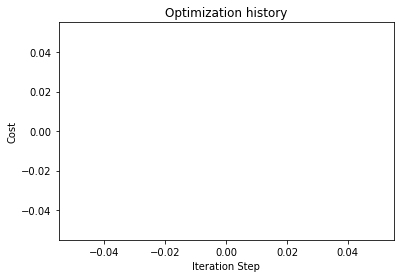

means: [-3.1533203124999996]
means: [-0.8359375000000002]
means: [-2.203125]
means: [-1.3017578125000002]
means: [-3.481445312499999]
means: [-0.35253906249999983]
means: [-0.33203124999999983]
means: [-0.6142578124999998]
means: [-2.4814453124999996]
means: [-0.5302734374999996]


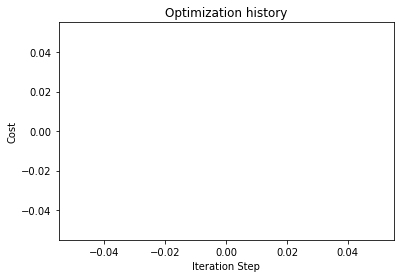

means: [-3.0009765624999996]
means: [0.1142578125]
means: [-3.86328125]
means: [-0.6904296874999999]
means: [-2.2333984375]
means: [-1.263671875]
means: [0.03027343750000011]
means: [0.3681640624999999]
means: [-3.0458984375000004]
means: [-0.8046875]


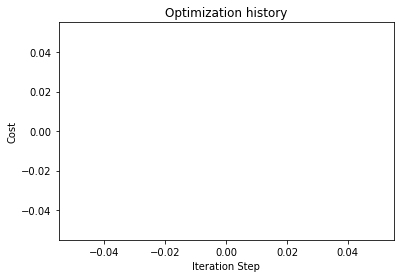

means: [-3.48046875]
means: [-0.306640625]
means: [-2.27734375]
means: [-0.8798828125]
means: [-3.34765625]
means: [-0.9199218750000002]
means: [0.4033203124999996]
means: [0.486328125]
means: [-3.7568359375000004]
means: [-0.4716796875000005]


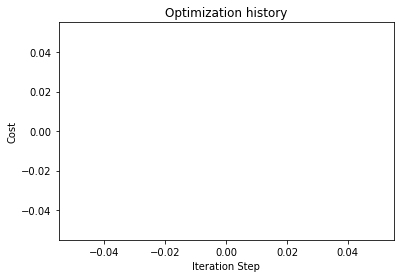

means: [-2.7216796874999996]
means: [-0.4472656249999996]
means: [-3.2421875]
means: [-0.3437499999999997]
means: [-3.3242187499999996]
means: [-0.6123046874999999]
means: [-0.31640624999999983]
means: [-0.08398437499999972]
means: [-3.1923828124999996]
means: [-0.8310546875]


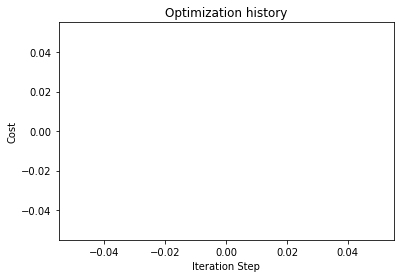

means: [-3.7119140624999996]
means: [-0.5712890625]
means: [-3.4228515624999996]
means: [-0.5478515624999998]
means: [-3.638671875]
means: [-0.5019531249999998]
means: [0.13281250000000008]
means: [0.68359375]
means: [-3.7978515624999996]
means: [-0.7265625000000002]


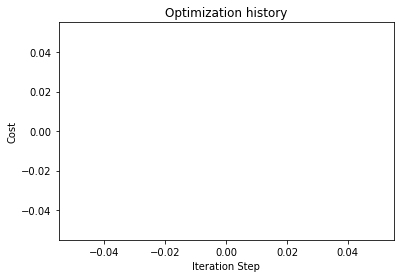

means: [-4.0771484375]
means: [-0.45703124999999967]
means: [-3.73828125]
means: [-0.6894531250000001]
means: [-3.9023437500000004]
means: [-0.4687499999999999]
means: [0.15136718750000022]
means: [-0.005859375000000111]
means: [-3.482421875]
means: [-1.015625]


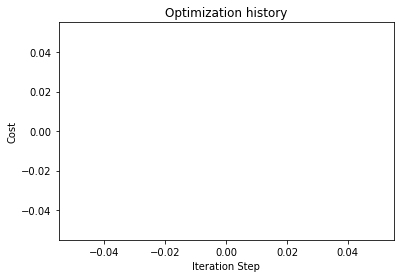

means: [-3.1875]
means: [-0.8906249999999997]
means: [-2.8964843750000004]
means: [-0.4677734374999999]
means: [-2.13671875]
means: [-0.6503906249999997]
means: [0.005859375]
means: [0.35546875000000067]
means: [-3.5595703124999996]
means: [-0.5283203124999999]


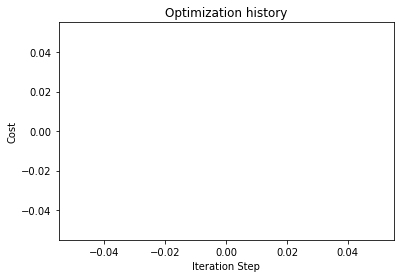

means: [-3.4892578125000004]
means: [-1.3749999999999996]
means: [-3.5478515624999996]
means: [0.36621093749999983]
means: [-4.369140625]
means: [-0.6083984375]
means: [-0.3769531250000001]
means: [0.35058593750000017]
means: [-3.404296875]
means: [-0.30664062499999983]


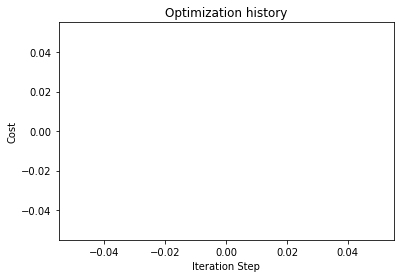

means: [-1.9775390625]
means: [-0.9140625]
means: [-2.1591796875]
means: [-0.857421875]
means: [-3.8583984375000004]
means: [-0.87890625]
means: [0.09863281249999996]
means: [-0.1005859375]
means: [-3.5400390624999996]
means: [-0.9912109375]


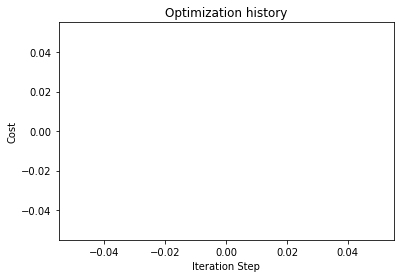

In [42]:
#init_params = [-3.33412359,  5.45892711]
init_params = [0.47267939,  3.07283929, -3.80560601,  3.86218767]
means_temp = []
for i in range(0, 10):
    #init_params = np.random.uniform(low=-2/np.pi, high=2/np.pi, size=(2,))
    noisy_opt_cost, noisy_opt_params, noisy_traj = minimize_cost(qaoa_mitigated_cost, init_params)
    means_temp.append(noisy_opt_cost)

In [43]:
np.mean(means_temp)

-29.448779296874996

In [44]:
np.median(means_temp)

-29.414794921874993

In [45]:
np.std(means_temp)

0.4859789692641492

In [46]:
np.mean(means_temp) / -35

0.8413936941964284

In [201]:
noisy_opt_cost

-26.45214843749999

In [202]:
noisy_opt_params

array([0.5 , 1.05])

In [ ]:
qaoa_p_means = []
qaoa_p_ratios = []
qaoa_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER)
    qaoa_p_means.append(m)
    qaoa_p_ratios.append(r)
    qaoa_p_approx_ratios.append(ar)

all_results["QAOA"] = [qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios]

In [ ]:
display_boxplots_results(qaoa_p_means, qaoa_p_ratios, qaoa_p_approx_ratios)

## QAOA with TQA

In [ ]:
from helpers.qaoa_helper import *

In [ ]:
tqa_p_means = []
tqa_p_ratios = []
tqa_p_approx_ratios = []
tqa_init_points = []

for p in range(1,MAX_P+1):
    tqa_initial_points = calculate_tqa(graph, p)
    m, r, ar = start_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, init_points=tqa_initial_points, maxiter=MAX_ITER)
    tqa_p_means.append(m)
    tqa_p_ratios.append(r)
    tqa_p_approx_ratios.append(ar)
    tqa_init_points.append(tqa_initial_points)
    
all_results["TQA QAOA"] = [tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, tqa_init_points]

In [ ]:
display_boxplots_results(tqa_p_means, tqa_p_ratios, tqa_p_approx_ratios, prefix='TQA ')

## WarmStart QAOA

In [ ]:
from helpers.warmstart_helper import *

In [ ]:
ws_p_means = []
ws_p_ratios = []
ws_p_approx_ratios = []
ws_opt_epsilons = []

for p in range(1,MAX_P+1):
    opt_epsilon = 0.25 #optimize_epsilon(max_cut, reps=p)
    m, r, ar = start_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_p_means.append(m)
    ws_p_ratios.append(r)
    ws_p_approx_ratios.append(ar)
    ws_opt_epsilons.append(opt_epsilon)
    
all_results["WarmStart QAOA"] = [ws_p_means, ws_p_ratios, ws_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_p_means, ws_p_ratios, ws_p_approx_ratios, prefix='WarmStart ')

### Recursive QAOA

In [ ]:
from helpers.recursive_qaoa_helper import *

In [ ]:
recursive_p_means = []
recursive_p_ratios = []
recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    m, r, ar = start_recursive_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, maxiter=MAX_ITER)
    recursive_p_means.append(m)
    recursive_p_ratios.append(r)
    recursive_p_approx_ratios.append(ar)

all_results["Recursive QAOA"] = [recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios]

In [ ]:
display_boxplots_results(recursive_p_means, recursive_p_ratios, recursive_p_approx_ratios, prefix='Recursive ')

### Recursive WarmStart QAOA

In [ ]:
from helpers.recursive_ws_helper import *

In [ ]:
ws_recursive_p_means = []
ws_recursive_p_ratios = []
ws_recursive_p_approx_ratios = []

for p in range(1,MAX_P+1):
    opt_epsilon = ws_opt_epsilons[p-1]
    m, r, ar = start_recursive_ws_qaoa_evaluation(max_cut, eval_num=EVAL_NUM, reps=p, epsilon=opt_epsilon, maxiter=MAX_ITER)
    ws_recursive_p_means.append(m)
    ws_recursive_p_ratios.append(r)
    ws_recursive_p_approx_ratios.append(ar)
    
all_results["Recursive WarmStart QAOA"] = [ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, ws_opt_epsilons]

In [ ]:
display_boxplots_results(ws_recursive_p_means, ws_recursive_p_ratios, ws_recursive_p_approx_ratios, prefix='Recursive WarmStart ')

## Results

In [ ]:
from helpers.results_helper import *

In [ ]:
means_df, ratio_df, approx_ratios_df = generate_dataframes(all_results)

### Metric Mean

In [ ]:
means_df

### Metric Ratio 

In [ ]:
ratio_df

### Metric Approximation Ratio

In [ ]:
approx_ratios_df

In [ ]:
# Save results 
filename = f'comparison_{BACKEND.name}_{graph.name}_results.npy'
with open(filename, 'wb') as f:
    np.save(f, all_results)
    print(f"Saved results to {filename}")